In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys

model = VGG16(weights='imagenet')

Using TensorFlow backend.


In [2]:
def predict(filename, featuresize):
    img = image.load_img(filename, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(preprocess_input(x))
    results = decode_predictions(preds, top=featuresize)[0]
    return results

def showimg(filename, title, i):
    im = Image.open(filename)
    im_list = np.asarray(im)
    plt.subplot(2, 5, i)
    plt.title(title)
    plt.axis("off")
    plt.imshow(im_list)

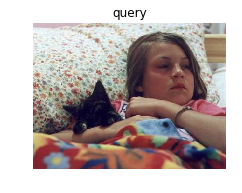

(u'n02104365', u'schipperke', 0.59594792)
(u'n02097298', u'Scotch_terrier', 0.12645917)
(u'n04033995', u'quilt', 0.048641127)
(u'n04344873', u'studio_couch', 0.029210055)
(u'n02105056', u'groenendael', 0.020743158)
(u'n02085620', u'Chihuahua', 0.013486148)
(u'n03131574', u'crib', 0.012940589)
(u'n02105412', u'kelpie', 0.011191898)
(u'n02108915', u'French_bulldog', 0.010560372)
(u'n02096177', u'cairn', 0.007881226)


In [3]:
filename = "dogs-vs-cats/train/mini/cat.6.jpg"
plt.figure(figsize=(20, 10))
for i in range(1):
    showimg(filename, "query", i+1)
plt.show()
results = predict(filename, 10)
for result in results:
    print(result)

In [4]:
import os
from path import Path
from elasticsearch import Elasticsearch

es = Elasticsearch(host='localhost', port=9200)

In [5]:
def createindex(indexname):
    if es.indices.exists(index=indexname):
        es.indices.delete(index=indexname)
    es.indices.create(index=indexname,  body={
        "index.mapping.total_fields.limit": 10000
    })

def loadimages(directory):
    imagefiles = []
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        imagefiles.append(filepath)
    return imagefiles

def indexfiles(directory, featuresize=10):
    imagefiles = loadimages(directory)
    for i in range(len(imagefiles)):
        filename = imagefiles[i]
        indexfile(filename, i, featuresize)
    es.indices.refresh(index="image-search")    

def indexfile(filename, i, featuresize):
    doc = {'filename': filename, 'synset':{}}
    results = predict(filename, featuresize) 
    for result in results:
        synset = doc['synset']
        synset[result[1]] = {
            'wnid': result[0], 
            'words': result[1], 
            'score': float(str(result[2]))
        }
    count = es.count(index='image-search', doc_type='image')['count']
    res = es.index(index="image-search", doc_type='image', id=(count + i), body=doc)

In [6]:
createindex("image-search")

# 110 dogs and 110 cats
directory = "dogs-vs-cats/train/mini/"
indexfiles(directory, 1000)

In [17]:
def searchimg(filename, num):
    plt.figure(figsize=(20, 10))
    for i in range(1):
        showimg(filename, "query", i+1)
    plt.show()
    results = predict(filename, num)
    search(results, num)

def search(synsets, num):
    inline = "1.000";
    for synset in synsets:
        words = synset[1]
        score = synset[2]
        inline += " + doc['synset." + words + ".score'].value * " + str(score)
    res = es.search(index="image-search", doc_type='image', body={
        "query": {
            "function_score": {
                "query": {"match_all": {}},
                "script_score" : {"script" : {"inline": inline}}
        }}})
    
    print("Got %d Hits:" % res['hits']['total'])
    for hit in res['hits']['hits'][0:num]:
        print "%s: %s [%s]" % (hit["_id"], hit["_source"]["filename"], hit["_score"])
    plt.figure(figsize=(20, 10))
    
    for i in range(len(res['hits']['hits'][0:num])):
        hit = res['hits']['hits'][0:num][i]
        showimg(hit["_source"]["filename"], hit["_id"], i+1)
    plt.show()

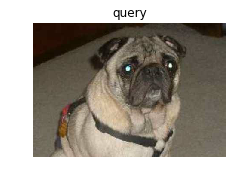

Got 221 Hits:
373: dogs-vs-cats/train/mini/dog.12466.jpg [1.6982338]
266: dogs-vs-cats/train/mini/dog.12412.jpg [1.0738012]
412: dogs-vs-cats/train/mini/dog.12485.jpg [1.0482345]
111: dogs-vs-cats/train/mini/cat.5.jpg [1.0263256]
309: dogs-vs-cats/train/mini/dog.12434.jpg [1.0226406]
437: dogs-vs-cats/train/mini/dog.12498.jpg [1.0131642]
386: dogs-vs-cats/train/mini/dog.12472.jpg [1.0073034]
381: dogs-vs-cats/train/mini/dog.12470.jpg [1.0071189]
339: dogs-vs-cats/train/mini/dog.12449.jpg [1.0069255]
403: dogs-vs-cats/train/mini/dog.12481.jpg [1.0061734]


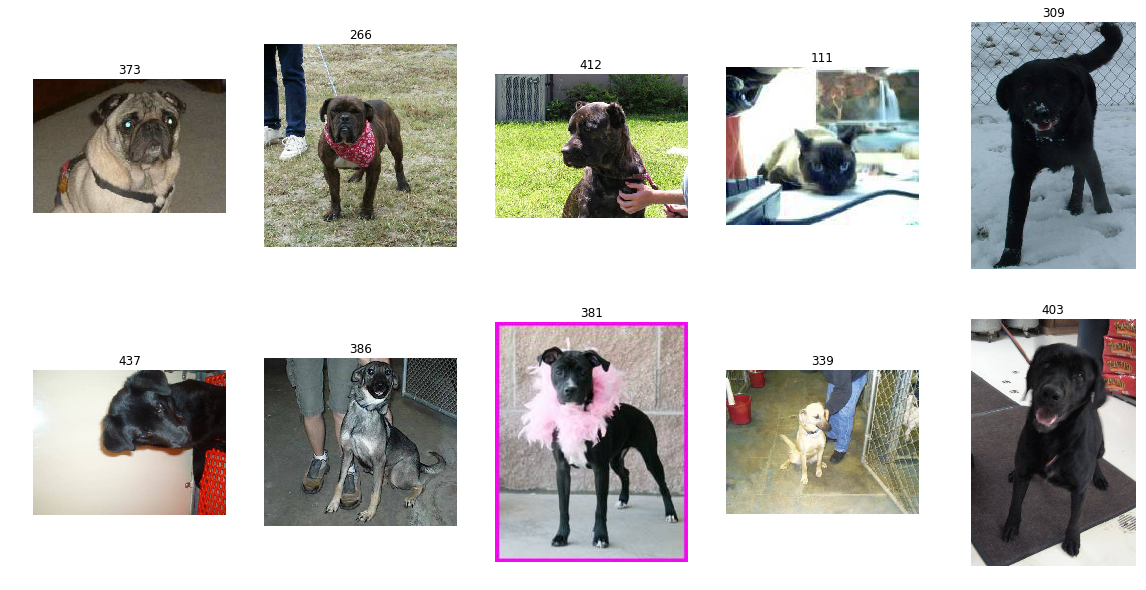

In [47]:
filename = "dogs-vs-cats/train/mini/dog.12466.jpg"
searchimg(filename, 10)

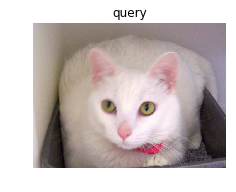

Got 10 Hits:
1: dogs-vs-cats/validation/cat/12495.jpg [1.0500922]
4: dogs-vs-cats/validation/cat/12496.jpg [1.0146325]
7: dogs-vs-cats/validation/cat/12500.jpg [1.0091451]
6: dogs-vs-cats/validation/dog/12491.jpg [1.0001391]
13: dogs-vs-cats/validation/dog/12499.jpg [1.0000734]
8: dogs-vs-cats/validation/dog/12493.jpg [1.0000379]
5: dogs-vs-cats/validation/dog/12490.jpg [1.0000176]
9: dogs-vs-cats/validation/dog/12494.jpg [1.0000066]
12: dogs-vs-cats/validation/dog/12498.jpg [1.0000056]
0: dogs-vs-cats/validation/cat/12492.jpg [1.0000005]


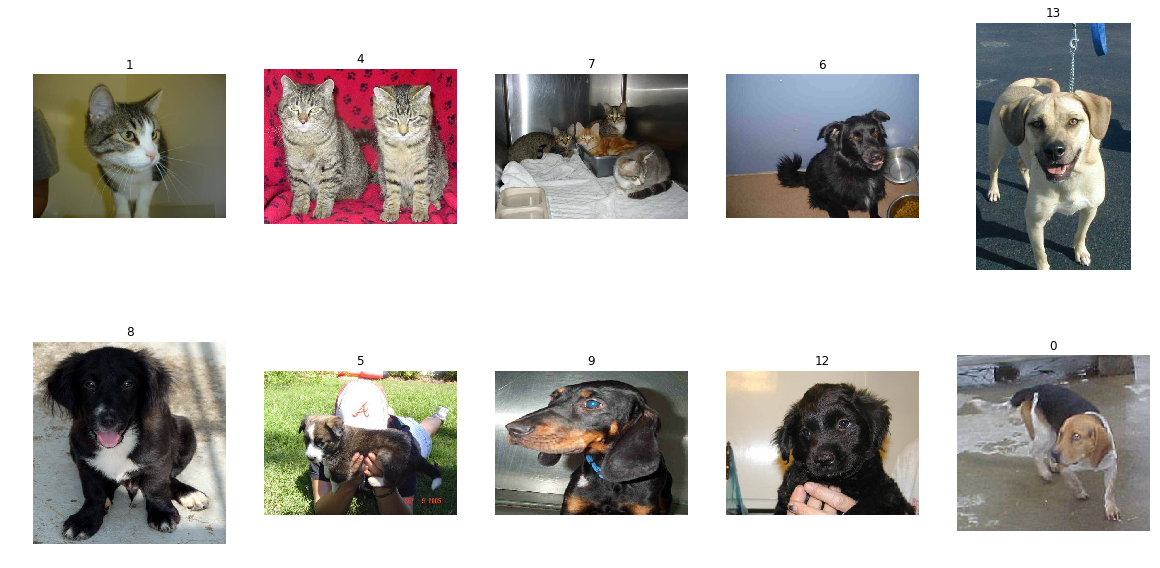

In [18]:
filename = "dogs-vs-cats/test1/4.jpg"
searchimg(filename, 10)

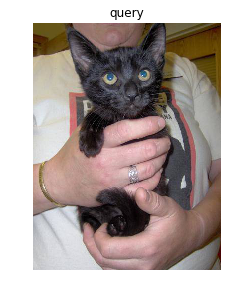

Got 10 Hits:
1: dogs-vs-cats/validation/cat/12495.jpg [1.0086681]
7: dogs-vs-cats/validation/cat/12500.jpg [1.0052712]
4: dogs-vs-cats/validation/cat/12496.jpg [1.0020891]
13: dogs-vs-cats/validation/dog/12499.jpg [1.0003467]
6: dogs-vs-cats/validation/dog/12491.jpg [1.0000774]
5: dogs-vs-cats/validation/dog/12490.jpg [1.000048]
8: dogs-vs-cats/validation/dog/12493.jpg [1.0000304]
12: dogs-vs-cats/validation/dog/12498.jpg [1.0000013]
9: dogs-vs-cats/validation/dog/12494.jpg [1.0000012]
0: dogs-vs-cats/validation/cat/12492.jpg [1.0000007]


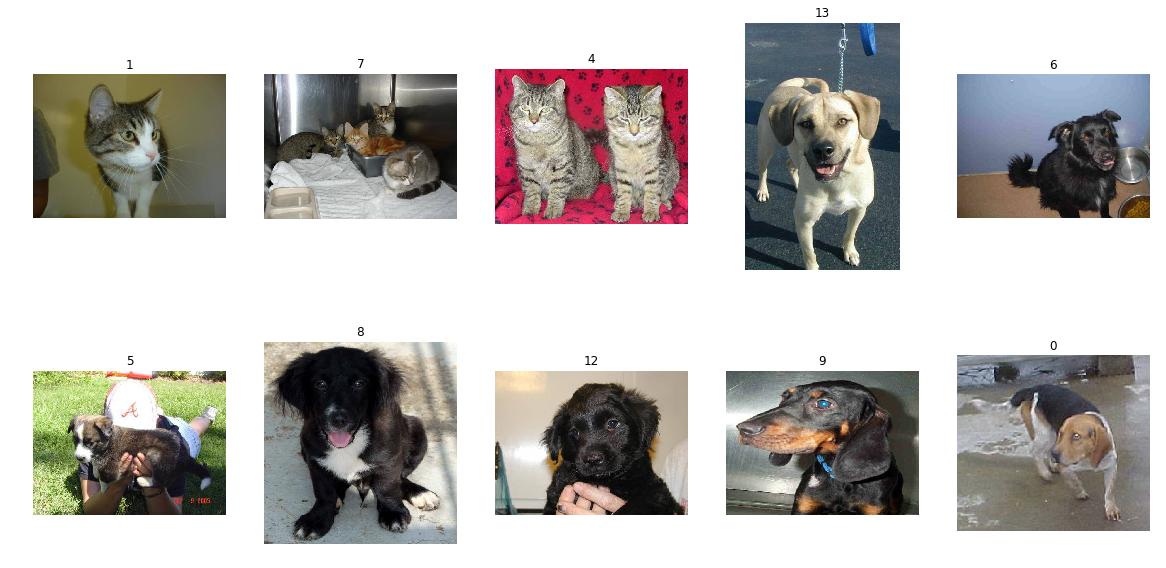

In [19]:
filename = "dogs-vs-cats/test1/38.jpg"
searchimg(filename, 10)

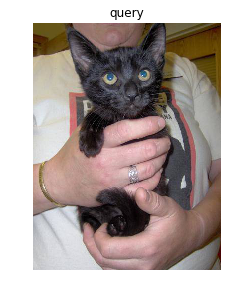

Got 10 Hits:
1: dogs-vs-cats/validation/cat/12495.jpg [1.0112127]
4: dogs-vs-cats/validation/cat/12496.jpg [1.0078272]
7: dogs-vs-cats/validation/cat/12500.jpg [1.0061389]
13: dogs-vs-cats/validation/dog/12499.jpg [1.0003737]
6: dogs-vs-cats/validation/dog/12491.jpg [1.0000994]
5: dogs-vs-cats/validation/dog/12490.jpg [1.0000817]
8: dogs-vs-cats/validation/dog/12493.jpg [1.000038]
9: dogs-vs-cats/validation/dog/12494.jpg [1.000007]
12: dogs-vs-cats/validation/dog/12498.jpg [1.0000017]
0: dogs-vs-cats/validation/cat/12492.jpg [1.0000008]


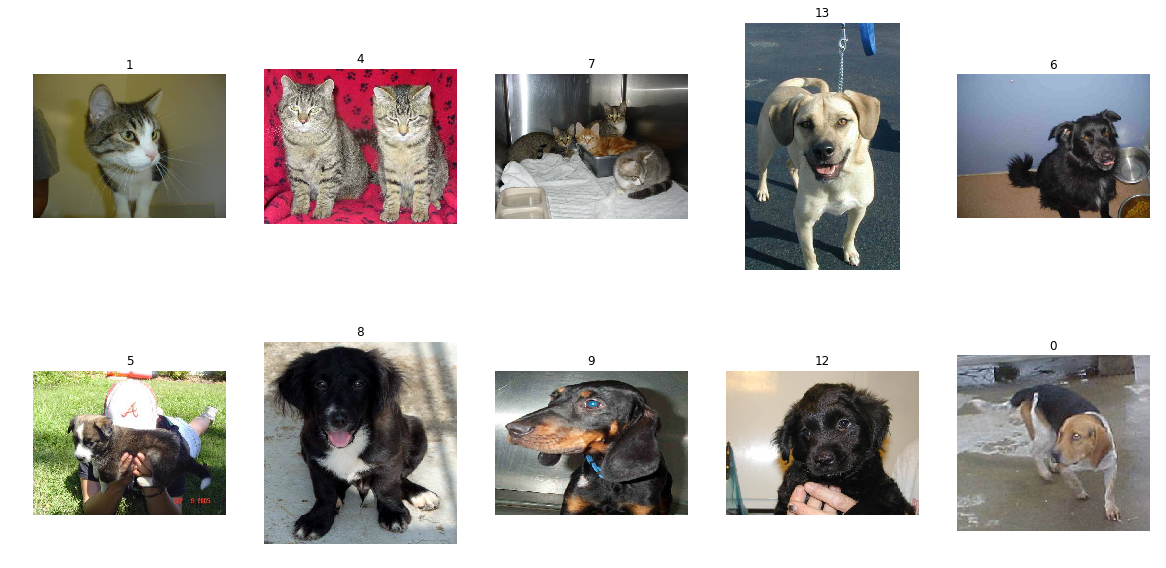

In [23]:
filename = "dogs-vs-cats/validation/12474.jpg"
searchimg(filename, 100)

In [24]:
filename = "dogs-vs-cats/train/mini/cat.7.jpg"
searchimg(filename, 10)

IOError: [Errno 2] No such file or directory: 'dogs-vs-cats/validation/cat/12499.jpg'

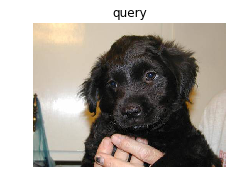

Got 10 Hits:
12: dogs-vs-cats/validation/dog/12498.jpg [1.7171967]
6: dogs-vs-cats/validation/dog/12491.jpg [1.4298215]
8: dogs-vs-cats/validation/dog/12493.jpg [1.0836569]
13: dogs-vs-cats/validation/dog/12499.jpg [1.0009426]
5: dogs-vs-cats/validation/dog/12490.jpg [1.000129]
9: dogs-vs-cats/validation/dog/12494.jpg [1.0000355]
1: dogs-vs-cats/validation/cat/12495.jpg [1.0000081]
7: dogs-vs-cats/validation/cat/12500.jpg [1.0000012]
0: dogs-vs-cats/validation/cat/12492.jpg [1.0000007]
4: dogs-vs-cats/validation/cat/12496.jpg [1.0]


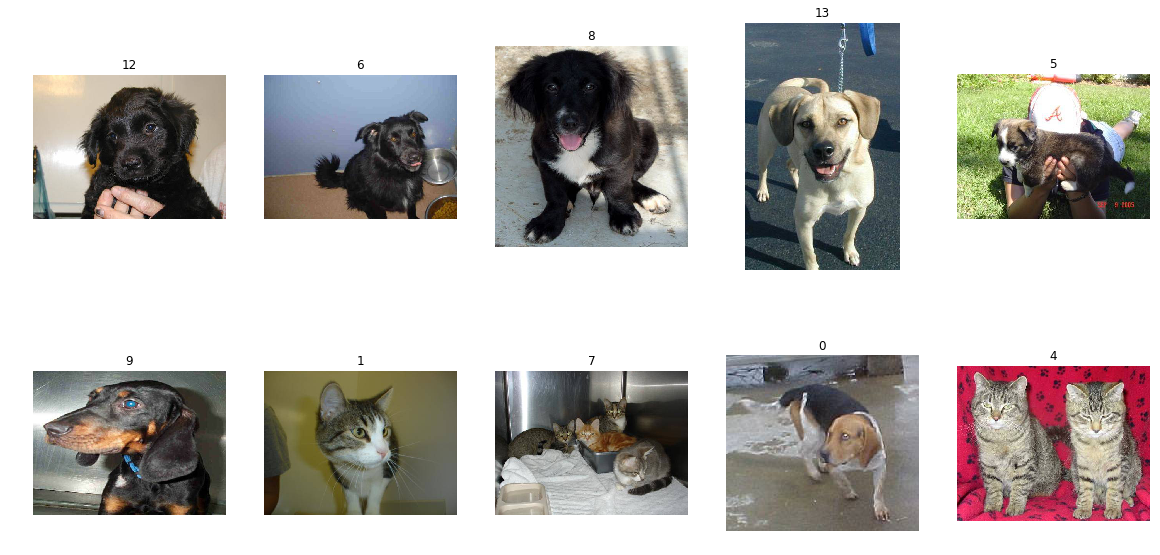

In [25]:
filename = "dogs-vs-cats/train/mini/dog.12466.jpg"
searchimg(filename, 10)